# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import gaussianMixtureNoiseModel
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from  https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download and created a noise model (GMM- and  histogram- based) using the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```). Ensure that for Convallaria, the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif``` and not the diaphragm data. 

In [2]:
path='../../../data/Convallaria_diaphragm/'
# Load the training data
data=imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif')
dataName='convallaria'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
# nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)
    

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 3.8466859459877014+-(2SEM)0.1143563898681531      
Epoch 1 finished      
avg. loss: 3.454468774795532+-(2SEM)0.11881562194062642      
Epoch 2 finished      
avg. loss: 3.313683533668518+-(2SEM)0.12644448679261364      
Epoch 3 finished      
avg. loss: 3.1499218106269837+-(2SEM)0.07654060650933911      
Epoch 4 finished      
avg. loss: 3.1383321046829225+-(2SEM)0.0978304554087872      
Epoch 5 finished      
avg. loss: 3.0355607628822328+-(2SEM)0.10766736206103161      
Epoch 6 finished      
avg. loss: 2.9512609958648683+-(2SEM)0.10250814356174279      
Epoch 7 finished      
avg. loss: 2.903929078578949+-(2SEM)0.13809111216937386      
Epoch 8 finished      
avg. loss: 2.887723708152771+-(2SEM)0.1311134851891859      
Epoch 9 finished      
avg. loss: 2.911033499240875+-(2SEM)0.10640266997892114      
Epoch 10 finished      
avg. loss: 2.8870890974998473+-(2SEM)0.11115995613328568      
Epoch 11 finished      
avg. loss: 2.8202059745788572+-(2SEM)

Epoch 91 finished      
avg. loss: 2.8199833035469055+-(2SEM)0.09317230098185947      
Epoch 92 finished      
avg. loss: 2.8448809146881104+-(2SEM)0.11298505229117607      
Epoch 93 finished      
avg. loss: 2.7314515352249145+-(2SEM)0.1029299146552891      
Epoch 94 finished      
avg. loss: 2.8003183960914613+-(2SEM)0.10838059184269573      
Epoch 95 finished      
avg. loss: 2.9035691618919373+-(2SEM)0.12860954256716586      
Epoch 96 finished      
avg. loss: 2.8266154527664185+-(2SEM)0.090028099023546      
Epoch 97 finished      
avg. loss: 2.743071103096008+-(2SEM)0.1109848879470613      
Epoch 98 finished      
avg. loss: 2.734607207775116+-(2SEM)0.09969828166019541      
Epoch 99 finished      
avg. loss: 2.8149508953094484+-(2SEM)0.06872014103428256      
Epoch 100 finished      
avg. loss: 2.7681418299674987+-(2SEM)0.08527695860868144      
Epoch 101 finished      
avg. loss: 2.7608110547065734+-(2SEM)0.08912266981257073      
Epoch 102 finished      
avg. loss: 2.882449615

Epoch 180 finished      
avg. loss: 2.7606058716773987+-(2SEM)0.08002175911579419      
Epoch 181 finished      
avg. loss: 2.7774770140647886+-(2SEM)0.09420235632562014      
Epoch 182 finished      
avg. loss: 2.7613124370574953+-(2SEM)0.10281666596513472      
Epoch 183 finished      
avg. loss: 2.834340286254883+-(2SEM)0.0688989749318013      
Epoch   183: reducing learning rate of group 0 to 6.1035e-08.
Epoch 184 finished      
avg. loss: 2.710382604598999+-(2SEM)0.087932650755205      
Epoch 185 finished      
avg. loss: 2.7655683159828186+-(2SEM)0.1163341474812937      
Epoch 186 finished      
avg. loss: 2.7717121958732607+-(2SEM)0.08288406220286616      
Epoch 187 finished      
avg. loss: 2.700965690612793+-(2SEM)0.08957124631830644      
Epoch 188 finished      
avg. loss: 2.8228259444236756+-(2SEM)0.12361035584107039      
Epoch 189 finished      
avg. loss: 2.7779471039772035+-(2SEM)0.10326022443643366      
Epoch 190 finished      
avg. loss: 2.7989821314811705+-(2SEM)0.1

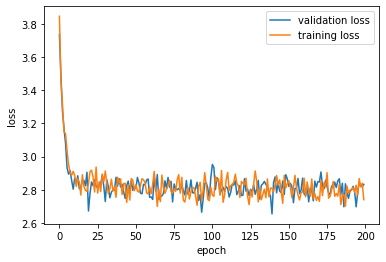

In [7]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()